In [ ]:
import numpy as np
import pandas as pd


f = pd.read_csv("GSE25628_samples.txt",sep='\t')
samp_data = f.to_numpy()
print(f.head())
#print("num entries:",len(samp_data))
sample_dict = {}
for idx in range(0,len(samp_data)):
    #print(samp_data[idx][0])
    #print(type(samp_data[idx][1]))
    #print(samp_data[idx][1])
    sample_dict[samp_data[idx][0]]=samp_data[idx][1]
print(sample_dict)

In [2]:
import numpy as np
import pandas as pd

def q3(df_healthy,df_disease):
    print(df_healthy.loc[df_healthy["SYMBOL"]=="BMP4"])
    print(df_healthy.loc[df_healthy["SYMBOL"]=="BMP4"].to_numpy())
    h_bmp4_row = df_healthy.loc[df_healthy["SYMBOL"]=="BMP4"].to_numpy()[0]
    h_bmp4_mean = np.mean(h_bmp4_row[1:len(h_bmp4_row)])
    print("h_bmp4_mean:",h_bmp4_mean)

    print(df_disease.loc[df_disease["SYMBOL"]=="BMP4"])
    dis_bmp4_row=df_disease.loc[df_disease["SYMBOL"]=="BMP4"].to_numpy()[0]
    dis_bmp4_mean = np.mean(dis_bmp4_row[1:len(dis_bmp4_row)])
    print("dis_bmp4_mean:",dis_bmp4_mean)
    print("dis to healthy ratio:",dis_bmp4_mean/h_bmp4_mean)#1.1908701280876066 wow this is really true. 1.2 is enough to cause disease? that sucks

def load_samples(file_name):
    '''
    input: filename of samples
    output: distionary, key=patient name, value=0 healthy, 1 diseased
    '''
    d = {}
    with open(file_name, "r") as fh:
        lines = fh.readlines()
        for line in lines:
            tokens = line.split()
            d[tokens[0]] = tokens[1]
    #print("d:",d)
    return d

def load_expression_data(file_name,drop):
    '''
    input: gene expression filename
    output: pandas dataframe
    '''
    df = pd.read_csv(file_name,sep='\t')
    data=df.to_numpy()
    if drop:
        df = df.drop(columns='SYMBOL')
    print(df.head())
    return df



def sep_healthy_diseased(d):
    '''
    input: dictionary of patients, key=patient name, value=0 or 1 where 0=healthy and 1=disease
    output: 2 lists, healthy and diseased patients
    '''
    healthy=["SYMBOL"]
    disease=["SYMBOL"]
    for x in d.keys():
        if d[x]=='1':
            disease.append(x)
        elif(d[x]=='0'):
            healthy.append(x)
    return healthy,disease

def dataframe_split_healthy_disease(df,healthy,disease):
    '''
    input: list of healthy patients in healthy and list of disease patients in disease, pandas dataframe of data in df
    output: 2 dataframe, df_healthy where columns are healthy patients and rows are genes, df_disease
    '''
    df_healthy=df[healthy]
    df_disease=df[disease]
    print("df_healthy:")
    print(df_healthy.head())
    print("df_disease:")
    print(df_disease.head())
    return df_healthy, df_disease

def calc_avg(df):
    '''
    input: dataframe of healthy or diseased patients
    output: dataframe
    '''
    #print("calc_avg df head:")
    #print(df.head())
    rows,cols = df.shape
    print("rows:",rows,"cols:",cols)
    print("before expansion df.cols:",df.columns)
    diff = [x+"_diff" for x in df.columns] #list of columns
    diff[0] = "avg" #symbol is the first column, replace with avg
    print("diff:",diff) #how to add these columns to existing dataframe? 
    column_data = [0.]*df.shape[0] #create list of number of rows long of zeros 
    print("column_data.shape:",len(column_data))
    for x in diff:
        df[x]=column_data #add columns
    print("------ expanded dataframe----------")
    print(df.head())
    print("-----------------------------------")
    print("df.cols:",df.columns)
    #convert to numpy array to get rid of SettingWithCopyWarning messages POS pandas
    df_np = df.to_numpy(copy=True)
    print("numpy head:")
    print(df_np[:3])
    print("df_np shape:",df_np.shape)
    row_names=df_np[:,0]
    col_names = df.columns.tolist()[1:cols]
    print("col_names",col_names)
    #compute average of 10k genes, this is bad because we arent vectorizing. We dont need this loop
    for idx in range(0,df_np.shape[0]):
        #print("idx:",idx)
        #print(df_np[idx,:])
        df_np[idx,cols]= round(df_np[idx,1:cols].mean(),2)
        #print("df_np[idx,:] verify average column set",df_np[idx,:])
        for x in range(1,cols):
            #print("numpy x:",x,type(x),df_np[idx,x+cols])
            np_mean_diff=round(df_np[idx,cols]-df_np[idx,x],2) #avg is df_np[idx,cols+1], diff is df_np[idx,x] 
            #print("np_mean_diff:",np_mean_diff)
            #print("before diff update:",df_np[idx,:])
            df_np[idx,cols+x] = np_mean_diff #index starts from 1 one for avg column bc one column wasted on symbol
            #print("after diff update:",df_np[idx,:])
        #print("after update numpy row is:",df_np[idx,:])
    #first create a tuple
    #add 1 to range bc we added avg as columns we only want column_diff
    patient = {}
    for idx in range(cols+1,df_np.shape[1]):
        print("idx:",idx,df_np.shape[1])
        print(col_names[idx-cols-1])
        gene_list = []
        sort_col = df_np[:,idx]
        #print("sort_col:",sort_col)
        #this makes a tuple list before sorting
        for j in range(0,len(sort_col)):
            #print("row_names[j]",j,row_names[j], sort_col[j])
            gene_list.append((row_names[j],sort_col[j]))
        print("before sorting gene_list:",gene_list[0:10])
        gene_list.sort(key = lambda x: x[1],reverse=True) 
        print("sorted gene_list:",col_names[idx-cols-1],gene_list[0:10])
        patient[col_names[idx-cols-1]] = (col_names[idx-cols-1],type(gene_list))
        print("len(patient):",len(patient))
    return patient
    
samp = load_samples("GSE25628_samples.txt")
print(samp)
df = load_expression_data("GSE25628_filtered_expression.txt",False)
healthy,disease=sep_healthy_diseased(samp)
print("healthy:",healthy, "disease:",disease)
df_healthy, df_disease = dataframe_split_healthy_disease(df,healthy,disease)
#q3(df_healthy,df_disease)

#dict
patient_healthy = calc_avg(df_healthy)
patient_disease = calc_avg(df_disease)



{'GSM629722': '0', 'GSM629724': '0', 'GSM629725': '0', 'GSM629727': '0', 'GSM629729': '0', 'GSM629735': '0', 'GSM629719': '1', 'GSM629721': '1', 'GSM629723': '1', 'GSM629726': '1', 'GSM629728': '1', 'GSM629730': '1', 'GSM629732': '1'}
   SYMBOL  GSM629719  GSM629721  GSM629723  GSM629726  GSM629728  GSM629730  \
0     A2M  10.782603  12.224706  11.727896  11.807600  12.064787  12.170485   
1  A4GALT   7.468264   7.076519   7.529791   7.172451   7.073430   6.980553   
2    AAAS   7.608572   7.784315   7.958451   8.025649   8.018630   7.375393   
3    AACS   8.400528   8.413255   8.387644   8.548757   8.047159   7.682527   
4   AAGAB   6.292121   5.599561   6.003853   5.749613   5.339957   6.086971   

   GSM629732  GSM629722  GSM629724  GSM629725  GSM629727  GSM629729  GSM629735  
0  12.268920  10.222550  10.196768  11.939311  10.366529  10.594714  10.416336  
1   6.625028   6.435303   6.828313   7.086718   6.331259   6.960688   6.403040  
2   7.705605   7.230928   7.441335   7.459882  

/Users/dougchang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


idx: 8 14
GSM629722
before sorting gene_list: [('A2M', 0.4), ('A4GALT', 0.23), ('AAAS', 0.1), ('AACS', 0.04), ('AAGAB', 0.06), ('AAK1', 0.15), ('AAMDC', -0.15), ('AAMP', -0.05), ('AAR2', 0.09), ('AARS', -0.11)]
sorted gene_list: GSM629722 [('GPX3', 3.06), ('CRISP3', 2.96), ('CHI3L1', 2.83), ('IGJ', 2.74), ('TCN1', 2.71), ('C4BPA', 2.68), ('CP', 2.64), ('MUC16', 2.51), ('CSTA', 2.44), ('KRT23', 2.42)]
len(patient): 1
idx: 9 14
GSM629724
before sorting gene_list: [('A2M', 0.42), ('A4GALT', -0.16), ('AAAS', -0.11), ('AACS', 0.0), ('AAGAB', 0.21), ('AAK1', -0.04), ('AAMDC', 0.17), ('AAMP', -0.16), ('AAR2', 0.11), ('AARS', -0.06)]
sorted gene_list: GSM629724 [('VNN1', 3.53), ('GSTT1', 3.48), ('IGF1', 3.35), ('CD36', 2.94), ('LRP4', 2.86), ('HSD17B2', 2.83), ('POPDC3', 2.77), ('CEP55', 2.75), ('ZBTB16', 2.72), ('RRM2', 2.61)]
len(patient): 2
idx: 10 14
GSM629725
before sorting gene_list: [('A2M', -1.32), ('A4GALT', -0.42), ('AAAS', -0.13), ('AACS', -0.05), ('AAGAB', -0.06), ('AAK1', -0.27), 

   SYMBOL  GSM629719  GSM629721  GSM629723  GSM629726  GSM629728  GSM629730  \
0     A2M  10.782603  12.224706  11.727896  11.807600  12.064787  12.170485   
1  A4GALT   7.468264   7.076519   7.529791   7.172451   7.073430   6.980553   
2    AAAS   7.608572   7.784315   7.958451   8.025649   8.018630   7.375393   
3    AACS   8.400528   8.413255   8.387644   8.548757   8.047159   7.682527   
4   AAGAB   6.292121   5.599561   6.003853   5.749613   5.339957   6.086971   

   GSM629732  GSM629722  GSM629724  GSM629725  GSM629727  GSM629729  GSM629735  
0  12.268920  10.222550  10.196768  11.939311  10.366529  10.594714  10.416336  
1   6.625028   6.435303   6.828313   7.086718   6.331259   6.960688   6.403040  
2   7.705605   7.230928   7.441335   7.459882   7.239895   7.244419   7.352893  
3   7.448159   8.127974   8.168758   8.223162   8.095394   8.243136   8.182277  
4   5.790569   6.271555   6.119289   6.393994   6.413306   6.314710   6.468349  
4991
MAPK3
30
-----------
num unique ge

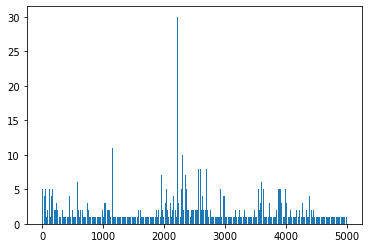

In [4]:
#each line is a gene set
import matplotlib.pyplot as plt
%matplotlib inline

def get_genes(df_small):
    '''
    input: dataframe from GSE25628_filtered_expression.txt
    output: return list of genes as 1 column w.10702 rows
    '''
    df_small = df.iloc[:,df.columns=="SYMBOL"]
    #print(df_small.head())
    genes = df_small.to_numpy()
    #print("genes:",genes,genes.shape)
    g_list = genes.flatten().tolist()
    #print(g_list)
    return g_list

def num_unique_genes(filename):
    with open(filename,'r') as fh:
        lines = fh.readlines()
    print("num lines:",len(lines))
    gene_hist = {}
    for i in range(0,len(lines)):
        #print(lines[i])
        tokens = lines[i].split()
        #print("pathway:",tokens[0])
        genes = tokens[2:]
        #print("genes:",tokens[2:])
        for g in genes:
            if g not in gene_hist:
                gene_hist[g] = 1
            else:
                gene_hist[g] = gene_hist[g]+1
    print("len gene_hist",len(gene_hist))
    print('num unique genes:',len(gene_hist.keys())) #4991

    
def q12(histogram):
    print("num unique genes:",len(histogram))
    X=range(0,len(histogram))
    plt.bar(X,histogram.values())
    plt.show()
    
def load_genesets(filename,g_list):
    '''
    input: kegg file, list of genes from GSE25628_filtered_expression.txt
    output: list of sets of genes. dont include genes which arent in GSE25628_filtered_expression.txt
    '''
    with open(filename,'r') as fh:
        lines = fh.readlines()
    #print("num lines:",len(lines))
    gene_list = []
    histogram={}
    for i in range(0,len(lines)):
        #print(lines[i])
        tokens = lines[i].split()
        #print("pathway:",tokens[0])
        genes = tokens[2:]
        #print("genes:",tokens[2:])
        gene_set=[]
        gene_set.append(tokens[0]) #append pathway to each list
        for g in genes:
            if g not in g_list:
                gene_set.append(g)
            if g not in histogram.keys():
                histogram[g]=1
            else:
                histogram[g]=histogram[g]+1
        gene_list.append(gene_set)
        #print("gene_set",gene_set)
    #print('gene_list:',gene_list) 
    return gene_list,histogram


df = load_expression_data("GSE25628_filtered_expression.txt",False)
genes = get_genes(df)    
gene_list,histogram = load_genesets("c2.cp.kegg.v6.2.symbols.filtered.gmt",genes)
print(len(histogram))
import operator
print(max(histogram.items(), key=operator.itemgetter(1))[0])
print(histogram["MAPK3"])
print("-----------")
q12(histogram)
#have sets of genes, need ranking to compute ES
#for gene_set in gene_list:
#    print("gene_set:",gene_set)

In [ ]:
#gene rank order